### MongoDB Challenges

##### Setup

Make sure that mongodb is setup and the database server (`mongod`) is running.

We are going to work with reviews of Heavy Metal movies. Hellz Yeah.
Unzip and unpickle the following file:

[heavy_metal_parsed.pkl.zip](heavy_metal_parsed.pkl.zip)

```
import pickle
with open("heavy_metal_parsed.pkl", 'r') as datafile:
    heavy_metal_reviews = pickle.load(datafile)
```

It's a list of dictionaries. One dictionary per review: perfect for a mongo document.
The key `raw` has the full text as a list of lines. For example, to see the first review, you can do:
```
first_review = heavy_metal_reviews[0]
for line in first_review['raw']:
    print line
```
which will give you:

    200 MOTELS (1971)
    DIRECTORS: Tony Palmer, Frank Zappa
    CAST: Frank Zappa, Ringo Starr, Mark Volman, Howard Kaylan, Keith Moon
    METAL CRED
    Frank Zappa
    Nun Desecration
    THE MEAT
    Beyond his metal sainthood for battling the censor-witches of the PMRC and getting named checked by Deep Purple in â€œSmoke on the Waterâ€, musical visionary Frank Zappa led many rock fans to heavy metal.
    And, from there, he led many metal fans to the outer expanses of rockâ€™s possibilities.
    Zappa also opened countless banging heads to the far reaches of jazz, classical, doo-wop, and any other art form that could involve (brilliant) noise and (brilliantly dumb) dirty jokes.
    200 Motels is Zappaâ€™s first crack at major motion picture madness, and it
    embodies the much forgotten cultural moment when acid rock tumbled forever into the black pits of rising heavy metal.
    Surrealistic sketches and psychedelic set pieces about the insanity of a being on tour are interspersed among performances in which the Mothers jam with London Philharmonic.
    Ringo Starr plays Zappa during the talking parts. Zappa himself, plays guitar throughout, demonstrating how very much of a six-string maestro he was, every lick on par with his future collaborators Steve Vail and Yngwie Malmsteen.
    SOLID METAL NUGGETS
    - A psychedelic cartoon interlude admiringly tweaks Black Sabbath and Grand Funk Railroad.
    - Keith Moon, madman drummer of the Who, pops upâ€”and offâ€”as â€œThe Hot Nun.â€

Let's see what other fields each document has:
```
print first_review.keys()
```
shows
```
['raw',
 'head',
 'metal_cred',
 'title',
 'direct',
 'solid_metal_nuggets',
 'cast',
 'the_meat',
 'year',
 'sections']
```
Basically, each section in the review is parsed into it's own key.

Ok, put these documents into a mongodb collection. For these challenges, do not use the `heavy_metal_reviews` list directly. Use mongo queries (you can use the mongo client directly or use pymongo from within python).

In [3]:
import pickle
with open("/home/ubuntu/raw_data/heavy_metal_parsed.pkl", 'rb') as datafile:
    heavy_metal_reviews = pickle.load(datafile)

In [11]:
from pymongo import MongoClient

client = MongoClient()
db = client.heavy_metal_db
#col = db.heavy_metal_collection

In [10]:
reviews = heavy_metal_reviews
reviews[0].keys()
reviews[0]
len(reviews)

856

In [13]:
hmm = client.heavy_metal_db.hmm
hmm.insert(reviews[0])
hmm.find().next()

for review in reviews[1:]:
    hmm.save(review)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: insert is deprecated. Use insert_one or insert_many instead.
  


DuplicateKeyError: E11000 duplicate key error collection: heavy_metal_db.hmm index: _id_ dup key: { : ObjectId('5994e8d5bcbe3f35a22961fc') }

In [15]:
#some basic exploration:
# lets see what one document looks like:
hmm.find_one()

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: save is deprecated. Use insert_one or replace_one instead
  


{'_id': ObjectId('5994e8d5bcbe3f35a22961fc'),
 'cast': ['Frank Zappa',
  'Ringo Starr',
  'Mark Volman',
  'Howard Kaylan',
  'Keith Moon'],
 'direct': ['Tony Palmer', 'Frank Zappa'],
 'head': ['200 MOTELS (1971)',
  'DIRECTORS: Tony Palmer, Frank Zappa',
  'CAST: Frank Zappa, Ringo Starr, Mark Volman, Howard Kaylan, Keith\nMoon'],
 'metal_cred': ['METAL CRED', 'Frank Zappa', 'Nun Desecration'],
 'raw': ['200 MOTELS (1971)',
  'DIRECTORS: Tony Palmer, Frank Zappa',
  'CAST: Frank Zappa, Ringo Starr, Mark Volman, Howard Kaylan, Keith\nMoon',
  'METAL CRED',
  'Frank Zappa',
  'Nun Desecration',
  'THE MEAT',
  'Beyond his metal sainthood for\nbattling the censor-witches of the PMRC and getting named checked by Deep\nPurple in “Smoke on the Water”, musical visionary Frank Zappa led many rock\nfans to heavy metal.',
  'And, from there, he led many metal\nfans to the outer expanses of rock’s possibilities.',
  'Zappa also opened countless banging\nheads to the far reaches of jazz, classica

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pprint import pprint

##### Challenge 1
Make a histogram of the years in the data. How many metal movies came
out over the years?

856

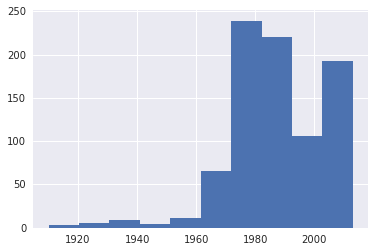

In [18]:
all_years = []
for film in hmm.find({}, {"year": 1, "_id": 0}):
    all_years.append(film["year"])

plt.hist(all_years)

hmm.find().count()

##### Challenge 2
Find the cast member that appeared in most Heavy Metal movies. Is
there one that is shared by more than one of these movies? Or are they
all completely different actors for every movie?

In [34]:
from bson.son import SON

#pipeline for aggregate:
cast_by_num_appearances = [  
            {"$unwind": "$cast"},
            {"$group": {"_id": "$cast", "count": {"$sum": 1}}},
            {"$sort": SON([("count", -1), ("_id", -1)])},
            {"$limit": 5}
            ]

pprint(list(hmm.aggregate(cast_by_num_appearances)))

[{'_id': '', 'count': 22},
 {'_id': 'Alice Cooper', 'count': 15},
 {'_id': 'Christopher Lee', 'count': 14},
 {'_id': 'Arnold Schwarzenegger', 'count': 10},
 {'_id': 'Ozzy Osbourne', 'count': 9}]


##### Challenge 3
Find the most used words in Heavy Metal film titles. Is there a word
that appears in a lot of them? Is it "The"? If it is something like
"the", How can you get around that? Find one "meaningful" word that
appears the most (this means non-structural word, unlike "the" or "a"
or "in")

In [60]:
projection = {"title":1, "_id":0}
titles = hmm.find( {} , projection )
list(titles)[:10]

[{'title': '200 MOTELS'},
 {'title': '300'},
 {'title': '1984'},
 {'title': '1990: BRONX WARRIORS'},
 {'title': '1991: THE YEAR PUNK BROKE'},
 {'title': '2001: A SPACE ODYSSEY'},
 {'title': '2019: AFTER THE FALL OF NEW YORK'},
 {'title': '2020 TEXAS GLADIATORS'},
 {'title': 'THE ABOMINABLE DR. PHIBES'},
 {'title': 'ABSURD'}]

##### Challenge 4
METAL CRED section lists themes included in these movies that makes
them more metal.
What were the top 5 metal cred keywords in the 70s? In 80s? In 90s, In
2000s?

##### Challenge 5
Let's use the length of the METAL CRED section as a proxy score for
how metal a movie is. Let's call this the METAL SCORE. To each mongo
document, add the metal_score as a new field.

##### Challenge 6
Find the director that is MOST METAL per movie (director with the
highest average metal score).
Remember that some movies have multiple directors.

##### Challenge 7
The majority of directors and actors will have worked on a single
movie. See if there are any directors that worked with an actor more
than once. If so, find the director-actor duo that have worked
together the most times.

##### Challenge 8
Create an index on the 'director' field to make the queries involving
it faster.
[What is an index?](http://en.wikipedia.org/wiki/Database_index)

[Creating an index in mongo](http://docs.mongodb.org/manual/tutorial/create-an-index/)
[Creating an index in pymongo](http://api.mongodb.org/python/current/api/pymongo/collection.html?highlight=create_index#pymongo.collection.Collection.create_index)
[Single field index on mongo](http://docs.mongodb.org/manual/core/index-single/)
[Mongo documentation on indexes](http://docs.mongodb.org/manual/core/indexes/)

##### Challenge 9 (Optional challenge for early finishers)
For each decade, make a histogram of metal scores.
Also, calculate the average metal score for each decade. Which decade
was the most pure metal decade?

##### Note (rather than a challenge)
In the latest version of mongo, you can do a text query.
To do this, you need to create one (only one) text-based index.
Let's index the_meat field so we can make text search queries on it
(in pymongo):

db.reviews.create_index([("the_meat", pymongo.TEXT,)])

Now you can do text search. For example, let's search for the phrase
"hitting power chords" within "the_meat" fields of all our documents.

    db.reviews.find({"$text": {"$search": "hitting power
    chords"}}).count()

    206

It has found 206 reviews. I can print the titles of the first 10
reviews that were returned in this text search:

    ten_matches = r.find({"$text": {"$search": "hitting power chords"}}).limit(10)
    for match in ten_matches:
        print match["title"]


    DOMINATOR
    REPO: THE GENETIC OPERA
    GREMLINS 2: THE NEW BATCH
    VICE SQUAD
    THE JERKY BOYS: THE MOVIE
    THE SONG REMAINS THE SAME
    THE EXORCIST
    THE CROW
    CANNIBAL HOLOCAUST
    HOSTEL

Enjoy your text searches : ) These can be very useful in some apps.


### Twitter API Extension

Create a mongo collection of tweets about something (anything you
choose).

Each mongo document should contain the text, username, favorite count
and retweet count of the tweet.